In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
import numpy as np
from random import randint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from sklearn.manifold import TSNE

### Zbadanie zbioru

In [2]:
df = pd.read_csv('ng20_all.csv', header=None)

In [3]:
labels = len(set(df[128]))
print('All labels: ', labels)
df[128]

All labels:  20


0         9
1         4
2        11
3         4
4         0
         ..
18841    12
18842     8
18843     4
18844     6
18845     7
Name: 128, Length: 18846, dtype: int64

### Przygotowanie danych do dalszych działań

In [4]:
Y = np.array(df[128])
X = np.array(df[range(128)])

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### Wizualizacja danych

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18846 samples in 1.065s...
[t-SNE] Computed neighbors for 18846 samples in 26.348s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18846
[t-SNE] Computed conditional probabilities for sample 2000 / 18846
[t-SNE] Computed conditional probabilities for sample 3000 / 18846
[t-SNE] Computed conditional probabilities for sample 4000 / 18846
[t-SNE] Computed conditional probabilities for sample 5000 / 18846
[t-SNE] Computed conditional probabilities for sample 6000 / 18846
[t-SNE] Computed conditional probabilities for sample 7000 / 18846
[t-SNE] Computed conditional probabilities for sample 8000 / 18846
[t-SNE] Computed conditional probabilities for sample 9000 / 18846
[t-SNE] Computed conditional probabilities for sample 10000 / 18846
[t-SNE] Computed conditional probabilities for sample 11000 / 18846
[t-SNE] Computed conditional probabilities for sample 12000 / 18846
[t-SNE] Computed conditional probabilities for s

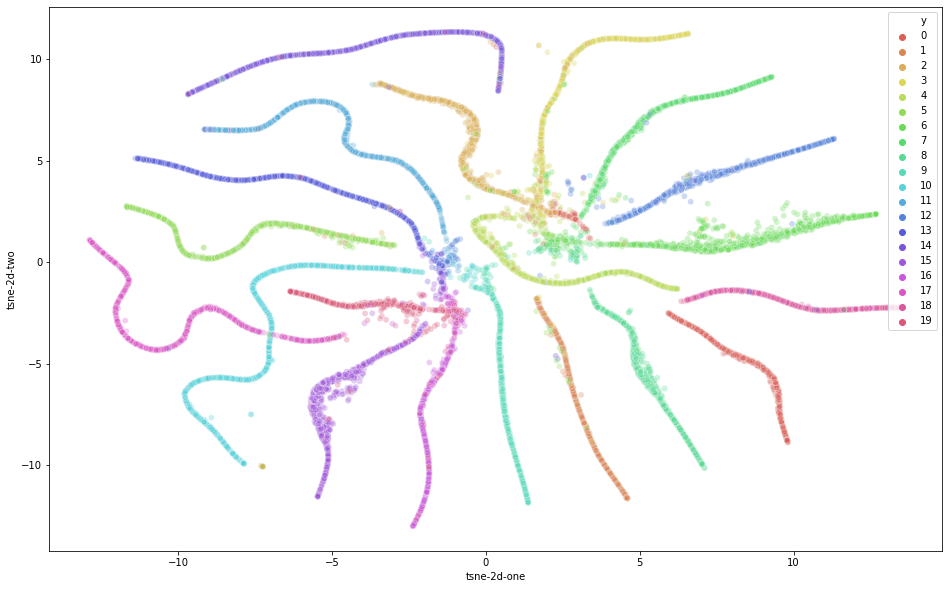

In [6]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
v_df = pd.DataFrame(X,columns=feat_cols)
v_df['y'] = Y
v_df['label'] = v_df['y'].apply(lambda i: str(i))
feat_cols = ['pixel'+str(i) for i in range(X.shape[1]) ]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(v_df)
v_df['tsne-2d-one'] = tsne_results[:,0]
v_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 20),
    data=v_df,
    legend="full",
    alpha=0.3
)

## Metody pomocnicze 

In [7]:
def create_mlp(iters=200):
    return MLPClassifier(hidden_layer_sizes=(64,64,128,128,128,20),
                         max_iter=iters)

def create_ada(estimators=50):
    return AdaBoostClassifier(n_estimators=estimators, 
                              random_state=0, 
                              base_estimator=RandomForestClassifier(n_estimators=30, n_jobs=4))

In [8]:
def get_accuracy(clf, x_train = X_train, y_train = Y_train, x_test = X_test):
    clf.fit(x_train, y_train)
    Y_predicted = clf.predict(x_test)
    return accuracy_score(Y_predicted, Y_test)

### Zadanie 2

In [9]:
# initialization
mlp_clf = create_mlp()
ada_clf = create_ada()

In [10]:
mlp_accuracy = get_accuracy(mlp_clf)
ada_accuracy = get_accuracy(ada_clf)

results = []
results.append(['MLP', mlp_accuracy])
results.append(['ADA', ada_accuracy])

frame = pd.DataFrame(results, columns=['Classifier', 'Accuracy score'])
frame

,Classifier,Accuracy score
0,MLP,0.922281
1,ADA,0.939523


### Zadanie 3

In [11]:
noise_rate = [.1, .2, .3]
lower_bound = 0
upper_bound = 19

results =[]

for rate in noise_rate:
    X_unchanged, X_to_mix, Y_unchanged, Y_to_mix = train_test_split(X_train, Y_train, test_size=rate, random_state=1)
    Y_with_noise = []
    for y in Y_to_mix:
        new = y
        while new == y:
            new = randint(lower_bound, upper_bound)
        Y_with_noise.append(new)
    X_new_train = np.concatenate((X_unchanged, X_to_mix), axis=0)
    Y_new_train = np.concatenate((Y_unchanged, np.array(Y_with_noise)), axis=0)
    
    mlp_clf = create_mlp()
    ada_clf = create_ada()
    
    mlp_accuracy = get_accuracy(mlp_clf, X_new_train, Y_new_train)
    ada_accuracy = get_accuracy(ada_clf, X_new_train, Y_new_train)

    results.append([rate, 'MLP', mlp_accuracy])
    results.append([rate, 'ADA', ada_accuracy])


frame = pd.DataFrame(results, columns=['Noise rate', 'Classifier','Accuracy score'])
frame

/home/narogm/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/narogm/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/narogm/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Noise rate,Classifier,Accuracy score
0,0.1,MLP,0.891777
1,0.1,ADA,0.938992
2,0.2,MLP,0.861804
3,0.2,ADA,0.936870
4,0.3,MLP,0.839523
5,0.3,ADA,0.934748


### Zadanie 4

In [12]:
n_components = [ 40, 64, X_train.shape[1]]
results = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    mlp_clf = create_mlp()
    ada_clf = create_ada()

    mlp_accuracy = get_accuracy(mlp_clf, X_train_pca, x_test=X_test_pca)
    ada_accuracy = get_accuracy(ada_clf, X_train_pca, x_test=X_test_pca)
    
    results.append([n, 'MLP', mlp_accuracy])
    results.append([n, 'ADA', ada_accuracy])
    
frame = pd.DataFrame(results, columns=['Components', 'Classifier','Accuracy score'])
frame  

,Components,Classifier,Accuracy score
0,40,MLP,0.933952
1,40,ADA,0.937401
2,64,MLP,0.928647
3,64,ADA,0.934748
4,128,MLP,0.923607
5,128,ADA,0.931565


### Zadanie 5

In [13]:
metrics = ['accuracy', 'f1_weighted', 'neg_log_loss', ]

scores = {}

results = []

for metric in metrics:
    ada_scores = cross_val_score(estimator=create_ada(), X=X_train, y=Y_train, scoring=metric, cv=5, n_jobs=-1)
    mlp_scores = cross_val_score(estimator=create_mlp(), X=X_train, y=Y_train, scoring=metric, cv=5, n_jobs=-1)
    scores[metric] = (ada_scores, mlp_scores)
    results.append([metric, 'MLP', np.mean(mlp_scores)])
    results.append([metric, 'ADA', np.mean(ada_scores)])
    
    
print(scores)
frame = pd.DataFrame(results, columns=['Metric', 'Classifier','Score'])
frame

{'accuracy': (array([0.93700265, 0.93930348, 0.94262023, 0.93830846, 0.94063018]), array([0.9270557 , 0.93034826, 0.93698176, 0.93731343, 0.92835821])), 'f1_weighted': (array([0.93697052, 0.93680835, 0.94298463, 0.93880646, 0.94121067]), array([0.92971159, 0.93089951, 0.93109275, 0.92890636, 0.93259544])), 'neg_log_loss': (array([-0.45645363, -0.42716547, -0.3228854 , -0.48050068, -0.34845243]), array([-0.5839798 , -0.62200252, -0.52697936, -0.47215048, -0.59684756]))}


,Metric,Classifier,Score
0,accuracy,MLP,0.932011
1,accuracy,ADA,0.939573
2,f1_weighted,MLP,0.930641
3,f1_weighted,ADA,0.939356
4,neg_log_loss,MLP,-0.560392
5,neg_log_loss,ADA,-0.407092


### Precision-Recall

In [14]:
Y_train_bin = label_binarize(Y_train, classes=[*range(n)])
Y_test_bin = label_binarize(Y_test, classes=[*range(n)])
X_train = X_train[:]
X_test = X_test[:]
n = 20
print(Y_test_bin.shape)
print(Y_test.shape)
cls = OneVsRestClassifier(estimator=create_mlp())
cls.fit(X_train, Y_train_bin)
mlp_pred = cls.predict_proba(X_test)
cls = OneVsRestClassifier(estimator=create_ada())
cls.fit(X_train, Y_train_bin)
ada_pred = cls.predict_proba(X_test)

(3770, 128)
(3770,)


/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 20 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 22 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 23 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multicla

/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 20 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 22 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 23 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/home/narogm/.local/lib/python3.7/site-packages/sklearn/multicla

#####  MLP

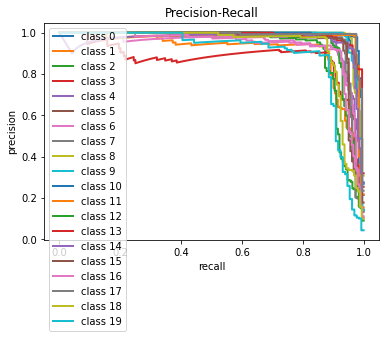

In [15]:
prec = dict()
rec = dict()
for i in range(n):
    prec[i], rec[i], _ = precision_recall_curve(Y_test_bin[:, i], mlp_pred[:, i])
    plt.plot(rec[i], prec[i], lw=2, label='class {}'.format(i))
plt.rcParams["figure.figsize"] = (10,10)    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision-Recall")
plt.show()

#####  AdaBoost

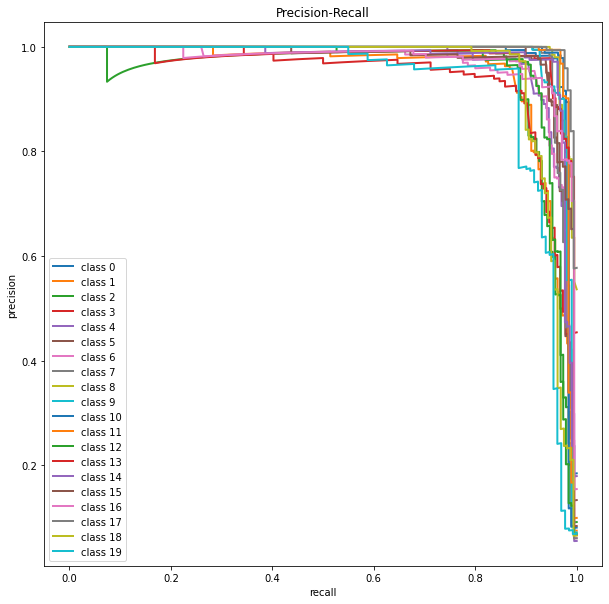

In [16]:
prec = dict()
rec = dict()
for i in range(n):
    prec[i], rec[i], _ = precision_recall_curve(Y_test_bin[:, i], ada_pred[:, i])
    plt.plot(rec[i], prec[i], lw=2, label='class {}'.format(i))
plt.rcParams["figure.figsize"] = (10,10)    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision-Recall")
plt.show()

### ROC

#####  MLP

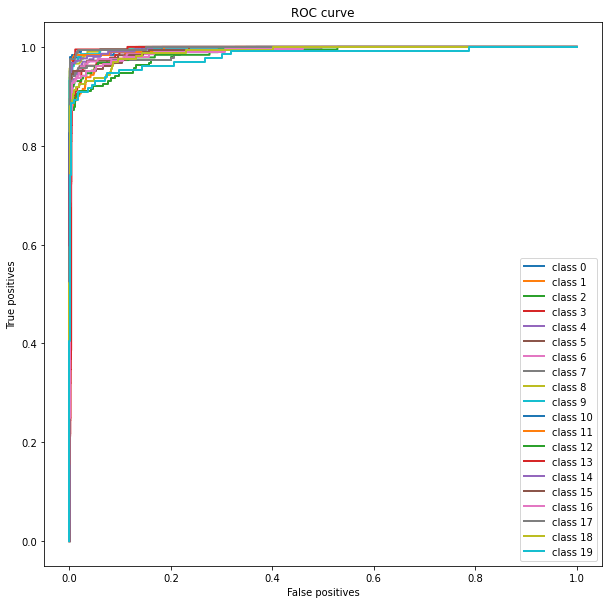

In [17]:
for i in range(n):
    fpr, tpr, _ = roc_curve(Y_test_bin[:, i], mlp_pred[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

#####  AdaBoost

No handles with labels found to put in legend.


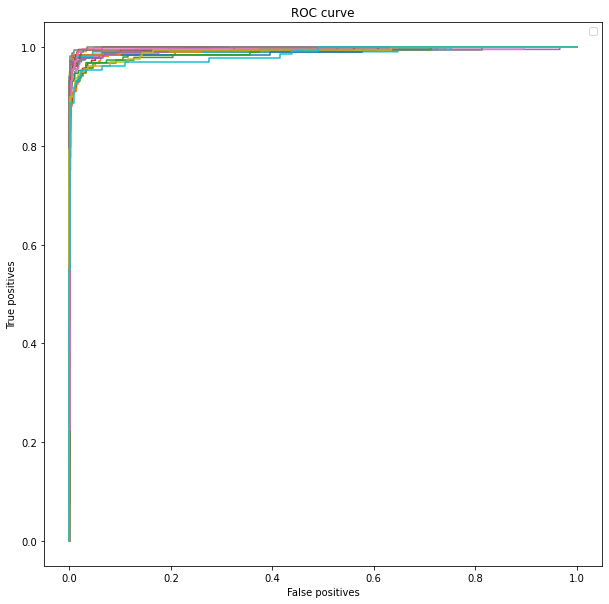

In [18]:
for i in range(n):
    fpr, tpr, _ = roc_curve(Y_test_bin[:, i], ada_pred[:, i])
    plt.plot(fpr, tpr)
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

### Zadanie 6

In [19]:
results = []

In [20]:
def test_classifier_with_parameter(clf_type, clf, n):
    start = time()
    clf.fit(X_train, Y_train)
    duration = time() - start

    Y_predicted = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_predicted)
    loss = log_loss(Y_test, clf.predict_proba(X_test))

    results.append([clf_type, n, duration, accuracy, loss])

In [21]:
mlp_iters = [50, 100, 200]
ada_estimators = [15, 25, 50]

for iters in mlp_iters:
    mlp_clf = create_mlp(iters)
    test_classifier_with_parameter('MLP', mlp_clf, iters)
    
    
for estimators in ada_estimators:
    ada_clf = create_ada(estimators)
    test_classifier_with_parameter('ADA', ada_clf, iters)
    
frame = pd.DataFrame(results, columns=['Classifier','max_iter/n_estimators','Duration','Accuracy','Loss'])
frame

/home/narogm/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/narogm/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Classifier,max_iter/n_estimators,Duration,Accuracy,Loss
0,MLP,50,26.948966,0.932095,0.322507
1,MLP,100,62.455808,0.932361,0.505439
2,MLP,200,68.137058,0.929443,0.581500
3,ADA,200,11.209600,0.938992,0.433677
4,ADA,200,18.162150,0.940318,0.393977
5,ADA,200,35.712899,0.938196,0.377344


### Zadanie 8

In [22]:
random_forest_clf = RandomForestClassifier(n_jobs = -1)
random_forest_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [23]:
random_forest_clf.feature_importances_

array([4.48601385e-05, 4.29100290e-04, 3.99584824e-03, 2.12265806e-03,
       1.09667162e-02, 1.26292727e-02, 0.00000000e+00, 4.42355656e-03,
       6.75297891e-04, 7.58807219e-03, 1.38592163e-02, 9.01006625e-03,
       8.24608804e-03, 9.89578976e-03, 1.25608754e-02, 1.68839491e-02,
       1.80353518e-02, 1.19168982e-02, 1.28699386e-02, 3.91219318e-03,
       5.69944526e-03, 6.98093672e-06, 1.76126664e-03, 8.90635419e-03,
       1.29891758e-02, 4.40450410e-03, 1.17138274e-04, 1.42338607e-02,
       3.72610622e-03, 1.03838413e-02, 0.00000000e+00, 1.60169906e-02,
       1.57236329e-02, 2.22709783e-02, 4.81860865e-03, 1.13995915e-02,
       8.65594389e-03, 5.87894830e-03, 6.12537567e-03, 1.55009457e-05,
       7.34949543e-03, 4.71924323e-03, 6.09324700e-03, 4.91944844e-03,
       1.16377021e-05, 1.43207939e-02, 3.07088430e-05, 1.01265171e-02,
       4.58528438e-03, 2.70076594e-03, 1.02321918e-02, 1.12340408e-02,
       5.42784810e-03, 1.11013771e-02, 5.94573129e-03, 1.81057453e-02,
      

In [24]:
features_importance = [(value, feature_index)  for (feature_index, value) in enumerate(random_forest_clf.feature_importances_)]
features_importance.sort(reverse=True)

features_importance[:20]

[(0.022270978348142796, 33),
 (0.018105745284611265, 55),
 (0.01803535183583179, 16),
 (0.01766871832480823, 104),
 (0.01748565826355982, 95),
 (0.01697512012263653, 127),
 (0.01688394906637707, 15),
 (0.016797389651072702, 124),
 (0.01656588615281258, 115),
 (0.016053476849252287, 93),
 (0.01601699056746384, 31),
 (0.015723632903851828, 32),
 (0.015425453460649465, 60),
 (0.015375844312353091, 98),
 (0.014320793856455363, 45),
 (0.014233860693022576, 27),
 (0.01385921630852192, 10),
 (0.013666452076210804, 58),
 (0.013430477889892954, 116),
 (0.012989175810958698, 24)]